# Машинное обучение, ФКН ВШЭ

## Практическое задание 6. Разложение ошибки на смещение и разброс

### Общая информация

Дата выдачи: 20.11.2020

Мягкий дедлайн: 00:59MSK 02.12.2019

Жесткий дедлайн: 00:59MSK 07.12.2019

### Оценивание и штрафы
Каждая из задач имеет определенную «стоимость» (указана в скобках около задачи). Максимально допустимая оценка за работу — 10 баллов.

Сдавать задание после указанного срока сдачи нельзя. При выставлении неполного балла за задание в связи с наличием ошибок на усмотрение проверяющего предусмотрена возможность исправить работу на указанных в ответном письме условиях.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов (подробнее о плагиате см. на странице курса). Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

Неэффективная реализация кода может негативно отразиться на оценке.

### Формат сдачи
Задания сдаются через систему anytask. Посылка должна содержать:
* Ноутбук homework-practice-06-Username.ipynb

Username — ваша фамилия и имя на латинице именно в таком порядке

### О задании

В этом задании вам предстоит воспользоваться возможностями бутстрапа для оценки смещения и разброса алгоритмов машинного обучения. Делать мы это будем на данных boston:

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
from sklearn.datasets import load_boston

In [3]:
boston = load_boston()

In [4]:
X = boston["data"]
y = boston["target"]

In [5]:
X.shape, y.shape

((506, 13), (506,))

### Вычисление bias и variance с помощью бутстрапа
На лекции была выведено следующая формула, показывающая, как можно представить ошибку алгоритма регрессии в виде суммы трех компонент:
$$
L(\mu) = 
    \mathbb{E}_{x, y}\bigl[\mathbb{E}_{X}\bigl[ (y - \mu(X)(x))^2 \bigr]\bigr] = 
$$
$$
    \underbrace{\mathbb{E}_{x, y}\bigl[(y - \mathbb{E}[y|x] )^2\bigr]}_{\text{шум}} + \underbrace{\mathbb{E}_{x}\bigl[(\mathbb{E}_{X}[\mu(X)(x)] - \mathbb{E}[y|x] )^2\bigr]}_{\text{смещение}} +
    \underbrace{\mathbb{E}_{x}\bigl[\mathbb{E}_{X}\bigl[(\mu(X)(x) - \mathbb{E}_{X}[\mu(X)(x)] )^2\bigr]\bigr]}_{\text{разброс}},
$$
* $\mu(X)$ — алгоритм, обученный по выборке $X = \{(x_1, y_1), \dots (x_\ell, y_\ell)\}$;
* $\mu(X)(x)$ — ответ алгоритма, обученного по выборке $X$, на объекте $x$;
* $\mathbb{E}_{X}$ — мат. ожидание по всем возможным выборкам;
* $\mathbb{E}_{X}[\mu(X)(x)]$ — "средний" ответ алгоритма, обученного по всем возможным выборкам $X$, на объекте $x$.
    
С помощью этой формулы мы можем анализировать свойства алгоритма обучения модели $\mu$, если зададим вероятностную модель порождения пар $p(x, y)$.

В реальных задачах мы, конечно же, не знаем распределение на парах объект - правильный ответ. Однако у нас есть набор семплов из этого распределения (обучающую выборка), и мы можем использовать его, чтобы оценивать математические ожидания. Для оценки мат. ожиданий по выборкам мы будем пользоваться бутстрэпом - методом генерации "новых" выборок из одной с помощью выбора объектов с возвращением. Разберем несколько шагов на пути к оценке смещения и разброса.

#### Приближенное вычисление интегралов
На занятиях мы разбирали примеры аналитического вычисления смещения и разброса нескольких алгоритмов обучения. Для большинства моделей данных и алгоритмов обучения аналитически рассчитать математические ожидания в формулах не удастся. Однако мат. ожидания можно оценивать приближенно. Чтобы оценить математическое ожидание $\mathbb{E}_{\bar z} f(\bar z)$ функции от многомерной случайной величины $\bar z = (z_1, \dots, z_d)$, $\bar z \sim p(\bar z)$, можно сгенерировать выборку из распределения $p(\bar z)$ и усреднить значение функции на элементах этой выборки:
$$\mathbb{E}_{\bar z} f(z) = \int f(\bar z) p(\bar z) d \bar z \approx \frac 1 m \sum_{i=1}^m f(\bar z_i), \, \bar z_i \sim p(\bar z), i = 1, \dots, m.$$

Например, оценим $\mathbb{E}_z z^2,$ $z \sim \mathcal{N}(\mu=5, \sigma=3)$ (из теории вероятностей мы знаем, что
$\mathbb{E}_z z^2 = \sigma^2 + \mu^2 = 34$):

In [6]:
z = np.random.normal(loc=5, scale=3, size=1000)
(z**2).mean()

34.94615653341348

#### Оценивание $\mathbb{E}_{x, y}$
Оценить мат. ожидания по $x$ и по $x, y$, встречающиеся во всех трех компонентах разложения, несложно, потому что у нас есть выборка объектов из распределения данных $p(x, y)$:
$$ \mathbb{E}_{x} f(x) \approx \frac 1 N \sum_{i=1}^N f(x_i), \quad
\mathbb{E}_{x, y} f(x, y) \approx \frac 1 N \sum_{i=1}^N f(x_i, y_i),$$
где $N$ - число объектов в выборке, $\{(x_i, y_i)\}_{i=1}^N$ - сама выборка. 

#### Оценивание $\mathbb{E}_X$ с помощью бутстрапа
Чтобы оценить мат. ожидание по $X$, нам понадобится выборка из выборок:
$$\mathbb{E}_X f(X) \approx \frac 1 s \sum_{j=1}^s f(X_j),$$
где $X_j$ - $j$-я выборка. Чтобы их получить, мы можем воспользоваться бутстрапом - методом генерации выборок на основе выбора объектов с возвращением. Чтобы составить одну выборку, будем $N$ раз выбирать индекс объекта $i \sim \text{Uniform}(1 \dots N)$ и добавлять $i$-ю пару (объект, целевая переменная) в выборку. В результате в каждой выборке могут появиться повторяющиеся объекты, а какие-то объекты могут вовсе не войти в некоторые выборки.

#### Итоговый алгоритм оценки смещения и разброса алгоритма $a$
1. Сгенерировать $s$ выборок $X_j$ методом бутстрапа.
1. На каждой выборке $X_j$ обучить алгоритм $a_j$.
1. Для каждой выборки $X_j$ определить множество объектов $T_j$, не вошедших в нее (out-of-bag). Вычислить предсказания алгоритма $a_j$ на объектах $T_j$. 

Поскольку у нас есть только один ответ для каждого объекта, мы будем считать шум равным 0, а $\mathbb{E}[y|x]$ равным имеющемуся правильному ответу для объекта $x$. 

Итоговые оценки:
* Смещение: для одного объекта - квадрат разности среднего предсказания и правильного ответа. Среднее предсказание берется только по тем алгоритмам $a_j$, для которых этот объект входил в out-of-bag выборку $T_j$. Для получения общего смещения выполнить усреденение смещений по объектам.
* Разброс: для одного объекта - выборочная дисперсия предсказаний алгоритмов $a_j$, для которых этот объект входил в out-of-bag выборку $T_j$. Для получения общего разброса выполнить усреденение разбросов по объектам.
* Ошибка $L$: усреднить квадраты разностей предсказания и правильного ответа по всем выполненным предсказаниям для всех объектов.

В результате должно получиться, что ошибка приблизительно равна сумме смещения и разброса!

Алгоритм также вкратце описан по [ссылке](https://web.engr.oregonstate.edu/~tgd/classes/534/slides/part9.pdf) (слайды 19-21).

__1. (3 балла)__

Реализуйте описанный алгоритм. Обратите внимание, что если объект не вошел ни в одну из out-of-bag выборок, учитывать его в вычислении итоговых величин не нужно. Как обычно, разрешается использовать только один цикл - по выборкам (от 0 до num_runs-1).

In [7]:
from sklearn.utils import resample


def compute_biase_variance(regressor, X, y, num_runs=1000):
    """
    :param regressor: sklearn estimator with fit(...) and predict(...) method
    :param X: numpy-array representing training set ob objects, shape [n_obj, n_feat]
    :param y: numpy-array representing target for training objects, shape [n_obj]
    :param num_runs: int, number of samples (s in the description of the algorithm)

    :returns: bias (float), variance (float), error (float) 
    each value is computed using bootstrap
    """
    cnt = np.zeros(len(X))
    Bias = np.zeros(len(X))
    L_err = np.zeros(0)
    y_pred_sum = np.zeros(len(X))
    y_pred_sum_squared = np.zeros(len(X))

    for i in range(num_runs - 1):
        idxs = np.random.randint(X.shape[0], size=X.shape[0])
        out_of_bag = np.setdiff1d(np.arange(X.shape[0]), np.unique(idxs))

        regressor.fit(X[idxs], y[idxs])

        y_pred = regressor.predict(X[out_of_bag])
        y_pred_sum_squared[out_of_bag] += y_pred * y_pred
        y_pred_sum[out_of_bag] += y_pred
        cnt[out_of_bag] += 1

        L_err = np.concatenate([L_err, y_pred - y[out_of_bag]])

    pred_means = y_pred_sum / cnt
    Bias = ((pred_means - y) ** 2).mean()
    variance = (y_pred_sum_squared / cnt - (y_pred_sum / cnt) ** 2).mean()
    L = (L_err ** 2).mean()
    return Bias, variance, L
    

__2. (0 баллов)__

Оцените смещение, разброс и ошибку для трех алгоритмов с гиперпараметрами по умолчанию: линейная регрессия, решающее дерево, случайный лес.

In [10]:
### your code here
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import BaggingRegressor, GradientBoostingRegressor

Bias, variance, L = compute_biase_variance(LinearRegression(), X, y)
print('LinearRegression')
print('Bias:', Bias)
print('Variance:', variance)
print('error 𝐿:', L)
Bias, variance, L = compute_biase_variance(DecisionTreeRegressor(), X, y)
print('DecisionTreeRegressor')
print('Bias:', Bias)
print('Variance:', variance)
print('error 𝐿:', L)
Bias, variance, L = compute_biase_variance(RandomForestRegressor(n_jobs=-1), X, y)
print('RandomForestRegressor')
print('Bias:', Bias)
print('Variance:', variance)
print('error 𝐿:', L)


LinearRegression
Bias: 23.737027345735157
Variance: 0.9333277695238944
error 𝐿: 24.84617712491512
DecisionTreeRegressor
Bias: 10.456183338765225
Variance: 13.108565732096334
error 𝐿: 23.555962183263233
RandomForestRegressor
Bias: 10.710788033971845
Variance: 2.270609789005622
error 𝐿: 13.064556857144394


__3. (1 балл)__
Проанализируйте полученный результат. Согласуются ли полученные результаты с теми, что мы обсуждали на занятиях (с комментарием)?

__Your answer here:__
Линейная регрессия:Если в данных наблюдается лин. зависимость, смещение у модели небольшое.Иначе, смещение большое. Разброс маленький.

Решающее дерево: с гиперпараметрами по умолчанию дерево сильно переобучается под выборку, следовательно смещение получается малым. Разброс большой так, как модель чувствительна к выборке.

Случайный лес:
Благодаря композиции моделей снизился разброс, практически, при том же смещении


__4. (1 балл)__
Постройте бэггинг над всеми тремя моделями (линейная регрессия, решающее дерево, случайный лес). Вспомните обсуждение с лекции о том, во сколько раз в теории бэггинг уменьшает разброс базового алгоритма. Выполняется ли это в ваших экспериментах? Если нет, поясните, почему.

__Your answer here:__
В теории бэггинг уменьшает разброс в n раз, где n это кол-во базовых алгоритмов. На практике так не получается. В нашем алгоритме оценки ошибки и смещения у нас много предложений, не выполняющихся на наших данных, которых не так много.

In [12]:
Bias, variance, L = compute_biase_variance(BaggingRegressor(LinearRegression(),n_estimators = 8,random_state=777, n_jobs=-1), X, y)
print('LinearRegression')
print('Bias:', Bias)
print('Variance:', variance)
print('error 𝐿:', L)
Bias, variance, L = compute_biase_variance(BaggingRegressor(DecisionTreeRegressor(), n_estimators = 8, random_state=777,n_jobs=-1), X, y)
print('DecisionTreeRegressor')
print('Bias:', Bias)
print('Variance:', variance)
print('error 𝐿:', L)
Bias, variance, L = compute_biase_variance(BaggingRegressor(RandomForestRegressor(n_jobs=-1), n_estimators = 8, random_state=777,n_jobs=-1), X, y)
print('RandomForestRegressor')
print('Bias:', Bias)
print('Variance:', variance)
print('error 𝐿:', L)


LinearRegression
Bias: 23.733006730521527
Variance: 1.0433470681805943
error 𝐿: 24.883628634790455
DecisionTreeRegressor
Bias: 10.671167208611504
Variance: 3.692504166951597
error 𝐿: 14.358659693058797
RandomForestRegressor
Bias: 11.5984546947944
Variance: 1.3995891747290228
error 𝐿: 13.009981868469419


### Визуализация предсказаний базовых алгоритмов бэггинга

В материалах лекций можно найти изображение, похожее на мишень - визуализация алгоритмов с разным смещением и разным разбросом. В центре "мишени" - правильный ответ, а "попадания" - предсказания алгоритмов, обученных по разным выборкам. Построим похожее изображение на наших данных для трех алгоритмов. Наши "мишени" будут одномерными, потому что мы решаем задачу одномерной регрессии.

__5. (2 балла)__

Реализуйте фукнцию plot_predictions. Она должна выполнять следующие действия:
1. Случайно выбрать num_test_objects пар объект-целевая переменная из выборки X, y. Получится две выборки: маленькая X_test, y_test (выбранные тестовые объекты) и X_train, y_train (остальные объекты).
1. Сгенерировать num_runs выборок методом бутстарапа из X_train, y_train. На каждой выборке обучить алгоритм regressor и сделать предсказания для X_test.
1. Нарисовать scatter-график. По оси абсцисс - объекты тестовой выборки (номера от 0 до num_test_objects-1), по оси ординат - предсказания. В итоге получится num_test_objects столбиков с точками. Для каждого тестового объекта надо отметить одним цветом все предсказания для него, а также черным цветом отметить правильный ответ.
1. Подпишите оси и название графика (аргумент title).

In [59]:
from sklearn.model_selection import train_test_split

def plot_predictions(regressor, X, y, num_runs=100, num_test_objects=10, title="", ax = None):
    """
    plot graphics described above
    """
    ### your code here

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=num_test_objects, random_state=69)
 
 
    for i in range(num_runs):
        idx = np.random.randint(0, len(X_train), len(X_train))
        X_j = X_train[idx]
        y_j = y_train[idx]
        y_pred = regressor.fit(
            X_j,
            y_j
        ).predict(X_test)
 
        x_ = np.arange(num_test_objects)
        y_ = y_pred
 
        ax.scatter(x_, y_,
                   c = range(len(X_test)))    #  цвет точек
 


    ax.scatter(np.arange(num_test_objects), y_test, c = '#000000',label='true')
    ax.set(title=title, xlabel='Objects', ylabel='Target', xticks=np.arange(num_test_objects))
    ax.grid(alpha=0.4)
    ax.legend()

__6. (0 баллов)__

Нарисуйте графики для линейной регрессии, решающего дерева и случайного леса. Нарисуйте три графика в строчку (это можно сделать с помощью plt.subplot) с одинаковой осью ординат (это важно для понимания масштаба разброса у разных алгоритмов):

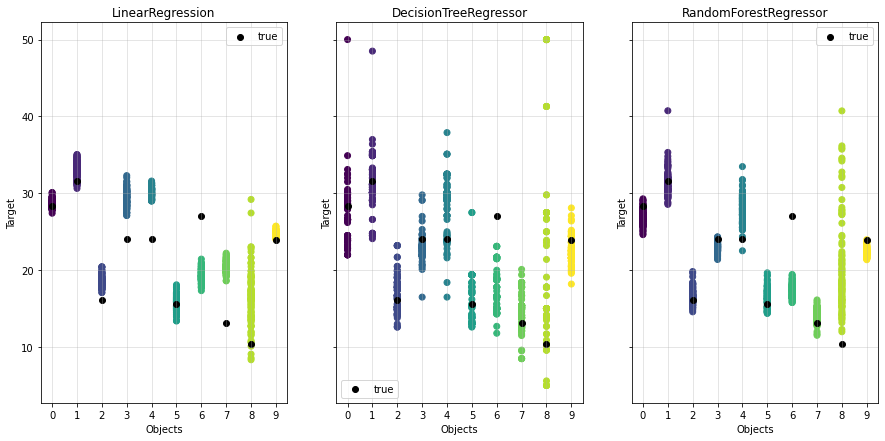

In [60]:
fig, axs = plt.subplots(1, 3, sharey=True, figsize=(15,7))

plot_predictions(LinearRegression(), X, y, title='LinearRegression', ax=axs[0])
plot_predictions(DecisionTreeRegressor(), X, y, title='DecisionTreeRegressor', ax=axs[1])
plot_predictions(RandomForestRegressor(n_jobs=-1), X, y, title='RandomForestRegressor', ax=axs[2])

__7. (1 балл)__

Для каждого графика прокомментируйте, как он характеризует смещение и разброс соответствующего алгоритма. 

__Your answer here:__
Смещение - положение цветных точек относительно черной точки(правильного ответа). разброс - положенние цветных точек относительно друг друга

Линейная регрессия:  
большое смещение, маленький разброс

Решающее дерево:  
Смещение небольшое, заметный разброс

Случайный лес:  
Смещение примерно такое как у дерева, но меньше разброс  

### Изменение bias и variance при изменении гиперпараметров

__8. (0 баллов)__

Постройте графики зависимости смещения и разброса от гиперпараметров решающего дерева max_depth (от 1 до 10) и max_features (от 1 до X.shape[1]):
Воспользуемся заметками с семинара

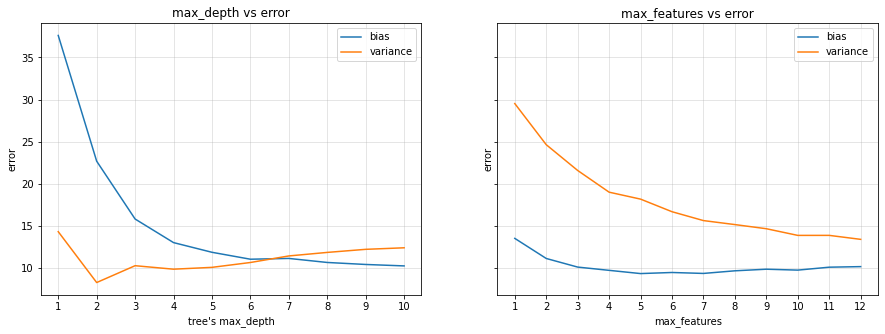

In [63]:
depth_biases, depth_variances, features_biases, features_variances = [], [], [], []
max_depths = np.arange(1, 11)
max_features = np.arange(1, X.shape[1])
for depth in max_depths:
    bias, variance, L = compute_biase_variance(DecisionTreeRegressor(max_depth=depth), X, y)
    depth_biases.append(bias)
    depth_variances.append(variance)

for features in max_features:
    bias, variance, L = compute_biase_variance(DecisionTreeRegressor(max_features=features), X, y)
    features_biases.append(bias)
    features_variances.append(variance)

fig, axs = plt.subplots(1, 2, sharey=True, figsize=(15, 5))

axs[0].plot(max_depths, depth_biases, label='bias')
axs[0].plot(max_depths, depth_variances, label='variance')
axs[0].grid(alpha=0.4)
axs[0].set(title='max_depth vs error', xlabel="tree's max_depth", ylabel='error', xticks=max_depths)
axs[0].legend()

axs[1].plot(max_features, features_biases, label='bias')
axs[1].plot(max_features, features_variances, label='variance')
axs[1].grid(alpha=0.4)
axs[1].set(title='max_features vs error', xlabel='max_features', ylabel='error', xticks=max_features)
axs[1].legend()

__9. (0 баллов)__

Постройте графики зависимости смещения и разброса от n_estimators (по сетке 2**np.arange(1, 10)) для случайного леса и градиентного бустинга:

In [ ]:
### your code here
from sklearn.ensemble import GradientBoostingRegressor

n_est = 2 ** np.arange(1, 10)
forest_biases, forest_variances, boost_biases, boost_variances = [], [], [], []

for n in n_est:
    bias, variance, L = compute_biase_variance(RandomForestRegressor(n_estimators=n), X, y)
    forest_biases.append(bias)
    forest_variances.append(variance)
    
    bias, variance, L = compute_biase_variance(GradientBoostingRegressor(n_estimators=n), X, y)
    boost_biases.append(bias)
    boost_variances.append(variance)

fig, axs = plt.subplots(1, 2, sharey=True, figsize=(15, 5))

axs[0].plot(np.arange(1, 10), forest_biases, label='bias')
axs[0].plot(np.arange(1, 10), forest_variances, label='variance')
axs[0].grid(alpha=0.4)
axs[0].set(title='n_estimators vs error (Random Forest)', xlabel='$\log_2$ n_estimators', ylabel='error', xticks=np.arange(1, 10))
axs[0].legend()

axs[1].plot(np.arange(1, 10), boost_biases, label='bias')
axs[1].plot(np.arange(1, 10), boost_variances, label='variance')
axs[1].grid(alpha=0.4)
axs[1].set(title='n_estimators vs error (Gradient Boosting)', xlabel='$\log_2$ n_estimators', ylabel='error', xticks=np.arange(1, 10))
axs[1].legend()

__10. (2 балла)__

Прокомментируйте графики (всего 4 графика): почему они имеют такой вид.

__Your answer here:__

 графики(8 номер):

График зависимости смещения и разброса от максимальной глубины дерева:

При небольших значениях глубины модель обучается несильно, поэтому смещение довольно большое, при этом разброс маленький поскольку дерево не переобучено. С увеличением максимальной глубины : модель начинает переобучаться, увеличивается разброс, уменьшается смещение

График зависимости смещения и разброса от максимального количества признаков дерева:

При небольших значениях max_features растет разброс, так как в модели слишком много рандома и на новых объектах предсказания получаются нестабильными. При маленьких значениях этого гиперпараметра, недостаточно данных для обучения и увеличивается смещение. С увеличением числа признаков предсказания стабилизируются, разброс уменьшается. Смещение уменьшается, поскольку глубина дерева не ограничена и можно подстроиться под данные


графики(9 номер):

График зависимости смещения и разброса от количества моделей в RandomForestRegressor: 

Констатное смещение у случайного леса согласуется с лекциями. При увеличении числа моделей разброс уменьшается, но не очень быстро, поскольку данных немного и часто строятся очень похожие модели 

График зависимости смещения и разброса от количества моделей в GradientBoostingRegressor:

Изначально используются только два дерева маленькой глубины, поэтому видим такое большое смещение. При росте числа моделей смещение сглаживается, поскольку модели компенсируют ошибки других моделей. Разброс небольшой, поскольку деревья маленькой глубины, а у них адекватная обобщающая способность. Но когда моделей становится много, в совокупности обобщающая способность чуть-чуть ухудшается и разброс незначительно повышается

2 кр и 7 дл на неделе

<img src="https://i.ytimg.com/vi/Wkgyj5y3hso/maxresdefault.jpg">